In [3]:
import numpy as np
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
import warnings
from sklearn.model_selection import train_test_split
import lifelines
import pandas as pd
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

In [4]:
def load_gbsg2(df=False):
    data = lifelines.datasets.load_gbsg2()
    data_encoded = pd.get_dummies(data, columns=["horTh", "menostat", "tgrade"])
    cols_to_scale = [ "age", "tsize", "pnodes", "progrec","estrec"]
    scaler = StandardScaler()
    scaler.fit(data_encoded[cols_to_scale])

    data_encoded[cols_to_scale] = scaler.transform(data_encoded[cols_to_scale])
    covariates = data_encoded.drop(["time", "cens"],axis = 1).to_numpy()
    event_times = data["time"].to_numpy()
    event_indicators = data["cens"].to_numpy()

    if df is True:
        return data_encoded
    else:
        return covariates, event_times, event_indicators

In [5]:
dataset = load_gbsg2(df=True).astype("float32")

N = dataset.shape[0]

time_column = "time"
event_column = "cens"
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

# Building training and testing sets
index_train, index_test = train_test_split( range(N), test_size = 0.1, random_state = 142857, stratify = dataset[event_column])
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )
N2 = data_train.shape[0]

index_train, index_val = train_test_split( range(N2), test_size = 0.1, random_state = 142857, stratify = data_train[event_column])
data_train = dataset.loc[index_train].reset_index( drop = True )
data_val  = dataset.loc[index_val].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test, X_val = data_train[features], data_test[features], data_val[features]
time_train, time_test, time_val = data_train[time_column], data_test[time_column], data_val[time_column]
event_train, event_test, event_val = data_train[event_column], data_test[event_column], data_val[event_column]


# X1_reshape = X
# X1_reshape_t = X_t
# delta = e
# delta_t = e_t
# y = t
# y_t = t_t

step = 10

In [6]:
# RSF
from sksurv.ensemble import RandomSurvivalForest
bool_indicator_train =  [bool(x) for x in event_train]
y_train_tuple =  c = np.array(list(zip(bool_indicator_train, time_train)), dtype=[("a", bool), ("b", float)])
rsf = RandomSurvivalForest(n_estimators=50, min_samples_split=10, 
                            min_samples_leaf=15, n_jobs=16)
rsf.fit(X_train, y_train_tuple)
rsf_func = rsf.predict_survival_function(X_test)
# survprob_rsf= np.array(1-rsf.predict_survival_function(X_test, times = np.arange(time_test.min(),time_test.max(),step)).T)
times = np.arange(time_test.min(),time_test.max(),step)
survprob_rsf = []
for i in range(X_test.shape[0]):
    survprob_rsf.append(1- rsf_func[i](times))


In [7]:
# CoxPH
from sksurv.linear_model import CoxPHSurvivalAnalysis
bool_indicator_train =  [bool(x) for x in event_train]
y_train_tuple =  c = np.array(list(zip(bool_indicator_train, time_train)), dtype=[("a", bool), ("b", float)])
CoxPH = CoxPHSurvivalAnalysis(alpha=0,verbose=0)

CoxPH.fit(X_train, y_train_tuple)
coxph_func = CoxPH.predict_survival_function(X_test)
# survprob_rsf= np.array(1-rsf.predict_survival_function(X_test, times = np.arange(time_test.min(),time_test.max(),step)).T)
times = np.arange(time_test.min(),time_test.max(),step)
survprob_coxph = []
for i in range(X_test.shape[0]):
    survprob_coxph.append(1- coxph_func[i](times))

In [8]:
# DeepSurv
from pycox.models import CoxPH
import torchtuples as tt
import torch
batch_size = 4096
epochs = 10000

y_train_tuple = (time_train.to_numpy(), event_train.to_numpy())
y_val_tuple = (time_val.to_numpy(), event_val.to_numpy())
val = X_val.to_numpy(), y_val_tuple
in_features = X_train.shape[1]
num_nodes = [32, 32, 32]
out_features = 1
batch_norm = True
dropout = 0.0
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                            dropout, output_bias=output_bias)
deepsurv = CoxPH(net, tt.optim.Adam, device=torch.device("cpu"))
deepsurv.optimizer.set_lr(0.001)
callbacks = [tt.callbacks.EarlyStopping(patience=100)]
verbose = False
log = deepsurv.fit(X_train.to_numpy(), y_train_tuple, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)
_ = deepsurv.compute_baseline_hazards()
deepsurv_pred = deepsurv.predict_surv_df(X_test.to_numpy())
prediction_timepoint = deepsurv_pred.index

survprob_deepsurv = []
for i in range(X_test.shape[0]):
    temp_list = []
    for time in prediction_timepoint:
        temp_list.append( 1- deepsurv_pred[i][time] )
    survprob_deepsurv.append(temp_list)

In [9]:
# CoxCC
from pycox.models import CoxCC
import torchtuples as tt
import torch
batch_size = 4096
epochs = 10000

y_train_tuple = (time_train.to_numpy(), event_train.to_numpy())
y_val_tuple = (time_val.to_numpy(), event_val.to_numpy())
val = X_val.to_numpy(), y_val_tuple
in_features = X_train.shape[1]
num_nodes = [32, 32, 32]
out_features = 1
batch_norm = True
dropout = 0.0
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                            dropout, output_bias=output_bias)
coxcc = CoxCC(net, tt.optim.Adam, device=torch.device("cpu"))
coxcc.optimizer.set_lr(0.001)
callbacks = [tt.callbacks.EarlyStopping(patience=100)]
verbose = False
log = coxcc.fit(X_train.to_numpy(), y_train_tuple, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)
_ = coxcc.compute_baseline_hazards()
coxcc_pred = coxcc.predict_surv_df(X_test.to_numpy())
prediction_timepoint = coxcc_pred.index

survprob_coxcc = []
for i in range(X_test.shape[0]):
    temp_list = []
    for time in prediction_timepoint:
        temp_list.append( 1- coxcc_pred[i][time] )
    survprob_coxcc.append(temp_list)

In [10]:
# DeepHit
from pycox.models import DeepHitSingle
import torchtuples as tt
import torch
torch.set_default_tensor_type(torch.FloatTensor)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_durations = 400
batch_size = 4096
epochs = 10000

labtrans = DeepHitSingle.label_transform(num_durations)
y_train_tuple = labtrans.fit_transform(time_train.to_numpy(), event_train.to_numpy())
y_val_tuple = labtrans.fit_transform(time_val.to_numpy(), event_val.to_numpy())
val = X_val.to_numpy(), y_val_tuple

in_features = X_train.shape[1]
num_nodes = [32, 32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.0
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
deephit = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts, device=device)
deephit.optimizer.set_lr(0.001)
callbacks = [tt.callbacks.EarlyStopping(patience=100)]
verbose = False
log = deephit.fit(X_train.to_numpy(), y_train_tuple, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)
deephit_pred = deephit.predict_surv_df(X_test.to_numpy())
prediction_timepoint = deephit_pred.index

survprob_deephit = []
for i in range(X_test.shape[0]):
    temp_list = []
    for time in prediction_timepoint:
        temp_list.append( 1- deephit_pred[i][time] )
    survprob_deephit.append(temp_list)

In [11]:
from pycox.models import PCHazard
import torchtuples as tt
import torch
torch.set_default_tensor_type(torch.FloatTensor)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 4096
epochs = 10000
num_durations = 400

labtrans = PCHazard.label_transform(num_durations)
y_train_tuple = labtrans.fit_transform(time_train.to_numpy(), event_train.to_numpy())
y_val_tuple = labtrans.fit_transform(time_val.to_numpy(), event_val.to_numpy())
val = X_val.to_numpy(), y_val_tuple

in_features = X_train.shape[1]
num_nodes = [100,100,100]
out_features = labtrans.out_features
batch_norm = False
dropout = 0.0
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
pchazard = PCHazard(net, tt.optim.Adam, device=device)
pchazard.optimizer.set_lr(0.0001)
callbacks = [tt.callbacks.EarlyStopping(patience=200)]
verbose = False
log = pchazard.fit(X_train.to_numpy(), y_train_tuple, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)
pchazard_pred = pchazard.predict_surv_df(X_test.to_numpy())
prediction_timepoint = pchazard_pred.index

survprob_pchazard = []
for i in range(X_test.shape[0]):
    temp_list = []
    for time in prediction_timepoint:
        temp_list.append( 1- pchazard_pred[i][time] )
    survprob_pchazard.append(temp_list)

In [13]:
from dcsurvival.dirac_phi import DiracPhi
from dcsurvival.survival import DCSurvival, sample
import torch.optim as optim
from tqdm import tqdm

torch.set_num_threads(16)
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

depth = 2
widths = [100, 100]
lc_w_range = (0, 1.0)
shift_w_range = (0., 2.0)
num_epochs = 100000
batch_size = 30000
early_stop_epochs = 1000

times_tensor_train = torch.tensor(time_train.to_numpy(), dtype=torch.float64).to(device)
event_indicator_tensor_train = torch.tensor(event_train.to_numpy(), dtype=torch.float64).to(device)
covariate_tensor_train = torch.tensor(X_train.to_numpy(), dtype=torch.float64).to(device)

times_tensor_val = torch.tensor(time_val.to_numpy(), dtype=torch.float64).to(device)
event_indicator_tensor_val = torch.tensor(event_val.to_numpy(), dtype=torch.float64).to(device)
covariate_tensor_val = torch.tensor(X_val.to_numpy(), dtype=torch.float64).to(device)

phi = DiracPhi(depth, widths, lc_w_range, shift_w_range, device, tol = 1e-14).to(device)
model = DCSurvival(phi, device = device, num_features=X_train.shape[1], tol=1e-14, hidden_size = 100).to(device)
optimizer_survival = optim.Adam([{"params": model.sumo_e.parameters(), "lr": 0.001},
                            {"params": model.sumo_c.parameters(), "lr": 0.001},
                        ])
optimizer_copula = optim.SGD([{"params": model.phi.parameters(), "lr": 0.0005}])

train_loss_per_epoch = []
print("Start training!")
for epoch in range(num_epochs):
    loss_per_minibatch = []
    for _i, (x , t, c) in enumerate(train_loader, 0):
        optimizer_copula.zero_grad()
        optimizer_survival.zero_grad()

        p = model(x, t, c, max_iter = 1000)
        logloss = -p
        logloss.backward()
        scalar_loss = (logloss/p.numel()).detach().cpu().numpy().item()

        optimizer_survival.step()

        if epoch > 200:
            optimizer_copula.step()
        # optimizer_censoring.step()
        # optimizer.step()

        loss_per_minibatch.append(scalar_loss/batch_size)
    train_loss_per_epoch.append(np.mean(loss_per_minibatch))
    if epoch % 1 == 0:
        print(f"Training likilihood at epoch {epoch}: {-train_loss_per_epoch[-1]:.5f}")
        # Check if validation loglikelihood has improved
        for _i, (x_val, t_val, c_val) in enumerate(val_loader, 0):
            val_loglikelihood = model(x_val, t_val, c_val, max_iter = 10000)/val_size
        print(f"Validation log-likelihood at epoch {epoch}: {val_loglikelihood.cpu().detach().numpy().item()}")
        if val_loglikelihood > best_val_loglikelihood:
            best_val_loglikelihood = val_loglikelihood
            epochs_no_improve = 0
            torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "loss": best_val_loglikelihood,
            }, "/home/DCSurvival/checkpoints/checkpoint_experiment_"+copula_form + "_" +str(theta_true)+".pth")

        else:
            epochs_no_improve += 1
        # Early stopping condition
        if epochs_no_improve == early_stop_epochs:
            print("Early stopping triggered at epoch: %s" % epoch)
            break
    # Plot Samples from the learned copula
    if epoch % 200 == 0:
        print("Scatter sampling")
        samples = sample(model, 2, sample_size, device =  device)
        plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), s=15)
        plt.savefig("/home/DCSurvival/sample_figs/"+copula_form+"/"+str(theta_true)+"/epoch%s.png" %
                    (epoch))
        plt.clf()

checkpoint = torch.load("/home/DCSurvival/checkpoints/checkpoint_experiment_"+copula_form + "_" +str(theta_true)+".pth")
model.load_state_dict(checkpoint["model_state_dict"])


times = np.arange(time_test.min(),time_test.max(),step)
times_tensor = torch.tensor(times).to(device)
covariate_tensor_test = torch.tensor(X_test.to_numpy(), dtype=torch.float64).to(device)

survprob_matrix_list = []

for time in times_tensor:
    temp = 1- model.survival(time, covariate_tensor_test).cpu().detach().numpy()
    survprob_matrix_list.append(temp)

survprob_matrix = np.vstack(survprob_matrix_list)
print(survprob_matrix.shape)
survprob_dcsurvival = list(survprob_matrix.transpose())

AttributeError: 'SurvivalCopula' object has no attribute 'sumo_e'

In [14]:
# y_l is the event time
y_l = []
prob_rsf = []
prob_coxph=[]
prob_deepsurv = []
prob_deephit = []
prob_pchazard = []
prob_coxcc = []
# prob_dcsurvival = []
for j in range(len(survprob_rsf)): #
    k = 0
    for i in np.arange(time_test.min(),time_test.max(),step): # from min to max of test time, the number of steps
        if k < len(survprob_rsf[0]):
            if i <= time_test[j]:
                y_l.append(0)
            else:
                y_l.append(1)
            prob_rsf.append(survprob_rsf[j][k])
            prob_coxph.append(survprob_coxph[j][k])
            k+=1
        else:
            break

for j in range(len(survprob_deepsurv)): #
    k = 0
    for i in np.arange(time_test.min(), time_test.max(), step): # from min to max of test time, the number of steps
        if k < len(survprob_deepsurv[0]):
            prob_deepsurv.append(survprob_deepsurv[j][k])
            prob_deephit.append(survprob_deephit[j][k])
            prob_pchazard.append(survprob_pchazard[j][k])
            prob_coxcc.append(survprob_coxcc[j][k])
            # prob_dcsurvival.append(survprob_dcsurvival[j][k])
            k+=1
        else:
            break

y_l = np.array(y_l)
prob_rsf = np.array(prob_rsf)
prob_coxph = np.array(prob_coxph)
prob_deepsurv = np.array(prob_deepsurv)
prob_deephit = np.array(prob_deephit)
prob_pchazard = np.array(prob_pchazard)
prob_coxcc = np.array(prob_coxcc)
# prob_dcsurvival = np.array(prob_dcsurvival)

[]

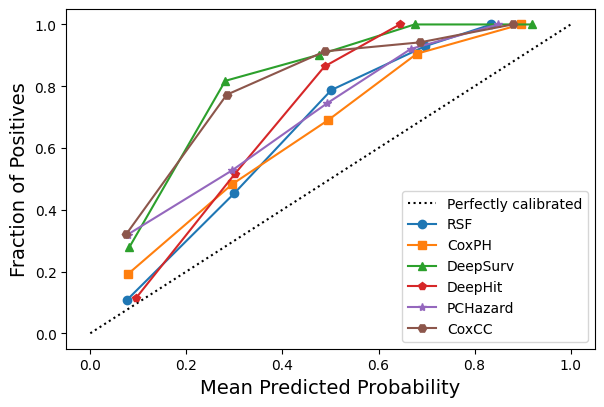

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(3, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:1, :1])

disp = CalibrationDisplay.from_predictions(y_l, prob_rsf, ax = ax_calibration_curve, name="RSF", marker="o")
disp = CalibrationDisplay.from_predictions(y_l, prob_coxph, ax = ax_calibration_curve, name="CoxPH", marker="s")
disp = CalibrationDisplay.from_predictions(y_l, prob_deepsurv, ax = ax_calibration_curve, name="DeepSurv", marker="^")
disp = CalibrationDisplay.from_predictions(y_l, prob_deephit, ax = ax_calibration_curve, name="DeepHit", marker="p")
disp = CalibrationDisplay.from_predictions(y_l, prob_pchazard, ax = ax_calibration_curve, name="PCHazard", marker="*")
disp = CalibrationDisplay.from_predictions(y_l, prob_coxcc, ax = ax_calibration_curve, name="CoxCC", marker="H")
# disp = CalibrationDisplay.from_predictions(y_l,prob_dcsurvival, ax = ax_calibration_curve, name="DCSurvival", marker="D")

ax_calibration_curve.set_xlabel("Mean Predicted Probability", fontsize=14)
ax_calibration_curve.set_ylabel("Fraction of Positives", fontsize=14)
ax_calibration_curve.legend(fontsize=10)

# ax_calibration_curve.grid()
#ax_calibration_curve.set_title("DD")
ax_calibration_curve.plot()